In [22]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [7]:
using Printf
using DataFrames
using JLD
using TempModel
using Dates: Date, DateTime
using GaussianProcesses: set_params!
import JSON

GPmodel="matern"
ICAO="KWRB"
data_dir="../data"
save_dir="/Volumes/Samsung250GB/saved"
k_nearest=5

5

In [8]:
let
    global k_spatiotemporal
    global logNoise
    if GPmodel=="fixed_var"
        k_spatiotemporal,logNoise = TempModel.fitted_sptemp_fixedvar()
    elseif GPmodel=="free_var"
        k_spatiotemporal,logNoise = TempModel.fitted_sptemp_freevar()
    elseif GPmodel=="sumprod"
        k_spatiotemporal,logNoise = TempModel.fitted_sptemp_sumprod()
    elseif GPmodel=="SExSE"
        k_spatiotemporal,logNoise = TempModel.fitted_sptemp_SExSE()
    elseif GPmodel=="diurnal"
        k_spatiotemporal,logNoise = TempModel.fitted_sptemp_diurnal()
    elseif GPmodel=="simpler"
        k_spatiotemporal,logNoise = TempModel.fitted_sptemp_simpler()
    elseif GPmodel=="matern"
        k_spatiotemporal,logNoise = TempModel.fitted_sptemp_matern()
    else
        error(@sprintf("unknown model: %s", GPmodel))
    end
end

# load kernel hyperparameters from JSON file
json_fname = @sprintf("hyperparams_%s_%s.json", GPmodel, ICAO)
json_filepath = joinpath(save_dir, "fitted_kernel", GPmodel, json_fname)
open(json_filepath, "r") do io
    global output_dictionary = JSON.parse(io)
end
@assert output_dictionary["test_ICAO"] == ICAO
hyp = Float64.(output_dictionary["hyp"])
set_params!(k_spatiotemporal, hyp[2:end])
logNoise = hyp[1]

epsg = 3857 # Web Mercator (m)
isdList = TempModel.read_isdList(; data_dir=data_dir, epsg=epsg)
isd_wData = TempModel.stations_with_data(isdList; data_dir=data_dir)

test_station = isd_wData[isd_wData[:ICAO].==ICAO, :]
@assert nrow(test_station) == 1
USAF = test_station[1, :USAF]
WBAN = test_station[1, :WBAN]

isd_nearest_and_test = TempModel.find_nearest(isd_wData, USAF, WBAN, k_nearest)

@show isd_nearest_and_test

hourly_cat=TempModel.read_Stations(isd_nearest_and_test; data_dir=data_dir)
itest=1 # first row of isd_nearest_and_test is the test station

isd_nearest_and_test = 6×13 DataFrame
│ Row │ USAF   │ WBAN   │ NAME                               │ CTRY    │ STATE   │ ICAO    │ LAT      │ LON      │ ELEV     │ BEGIN  │ END    │ X_PRJ      │ Y_PRJ     │
│     │ Int64⍰ │ Int64⍰ │ Union{Missing, String}             │ String⍰ │ String⍰ │ String⍰ │ Float64⍰ │ Float64⍰ │ Float64⍰ │ Int64⍰ │ Int64⍰ │ Float64    │ Float64   │
├─────┼────────┼────────┼────────────────────────────────────┼─────────┼─────────┼─────────┼──────────┼──────────┼──────────┼────────┼────────┼────────────┼───────────┤
│ 1   │ 722175 │ 13860  │ ROBINS AFB AIRPORT                 │ US      │ GA      │ KWRB    │ 32.633   │ -83.6    │ 89.6     │ 1942   │ 2015   │ -9.30631e6 │ 3.84669e6 │
│ 2   │ 722170 │ 3813   │ MIDDLE GEORGIA REGIONAL AIRPORT    │ US      │ GA      │ KMCN    │ 32.685   │ -83.653  │ 104.6    │ 1941   │ 2015   │ -9.31221e6 │ 3.85357e6 │
│ 3   │ 722250 │ 13829  │ LAWSON AAF AIRPORT                 │ US      │ GA      │ KLSF    │ 32.35    │ -85.0    │ 70

1

In [12]:
increm

2102392000 milliseconds

In [24]:
from = parse(DateTime, "2015-01-01T00:00:00")
to = parse(DateTime, "2015-03-14T23:59:36")

2015-03-14T23:59:36

In [33]:
ts = hourly_cat[:ts]
after_from = ts .>= from
before_to = ts .<= to
@show sum(from .<= ts .<= to)
@show sum(after_from .& before_to)

sum(from .<= ts .<= to) = 18454
sum(after_from .& before_to) = 18454


18454

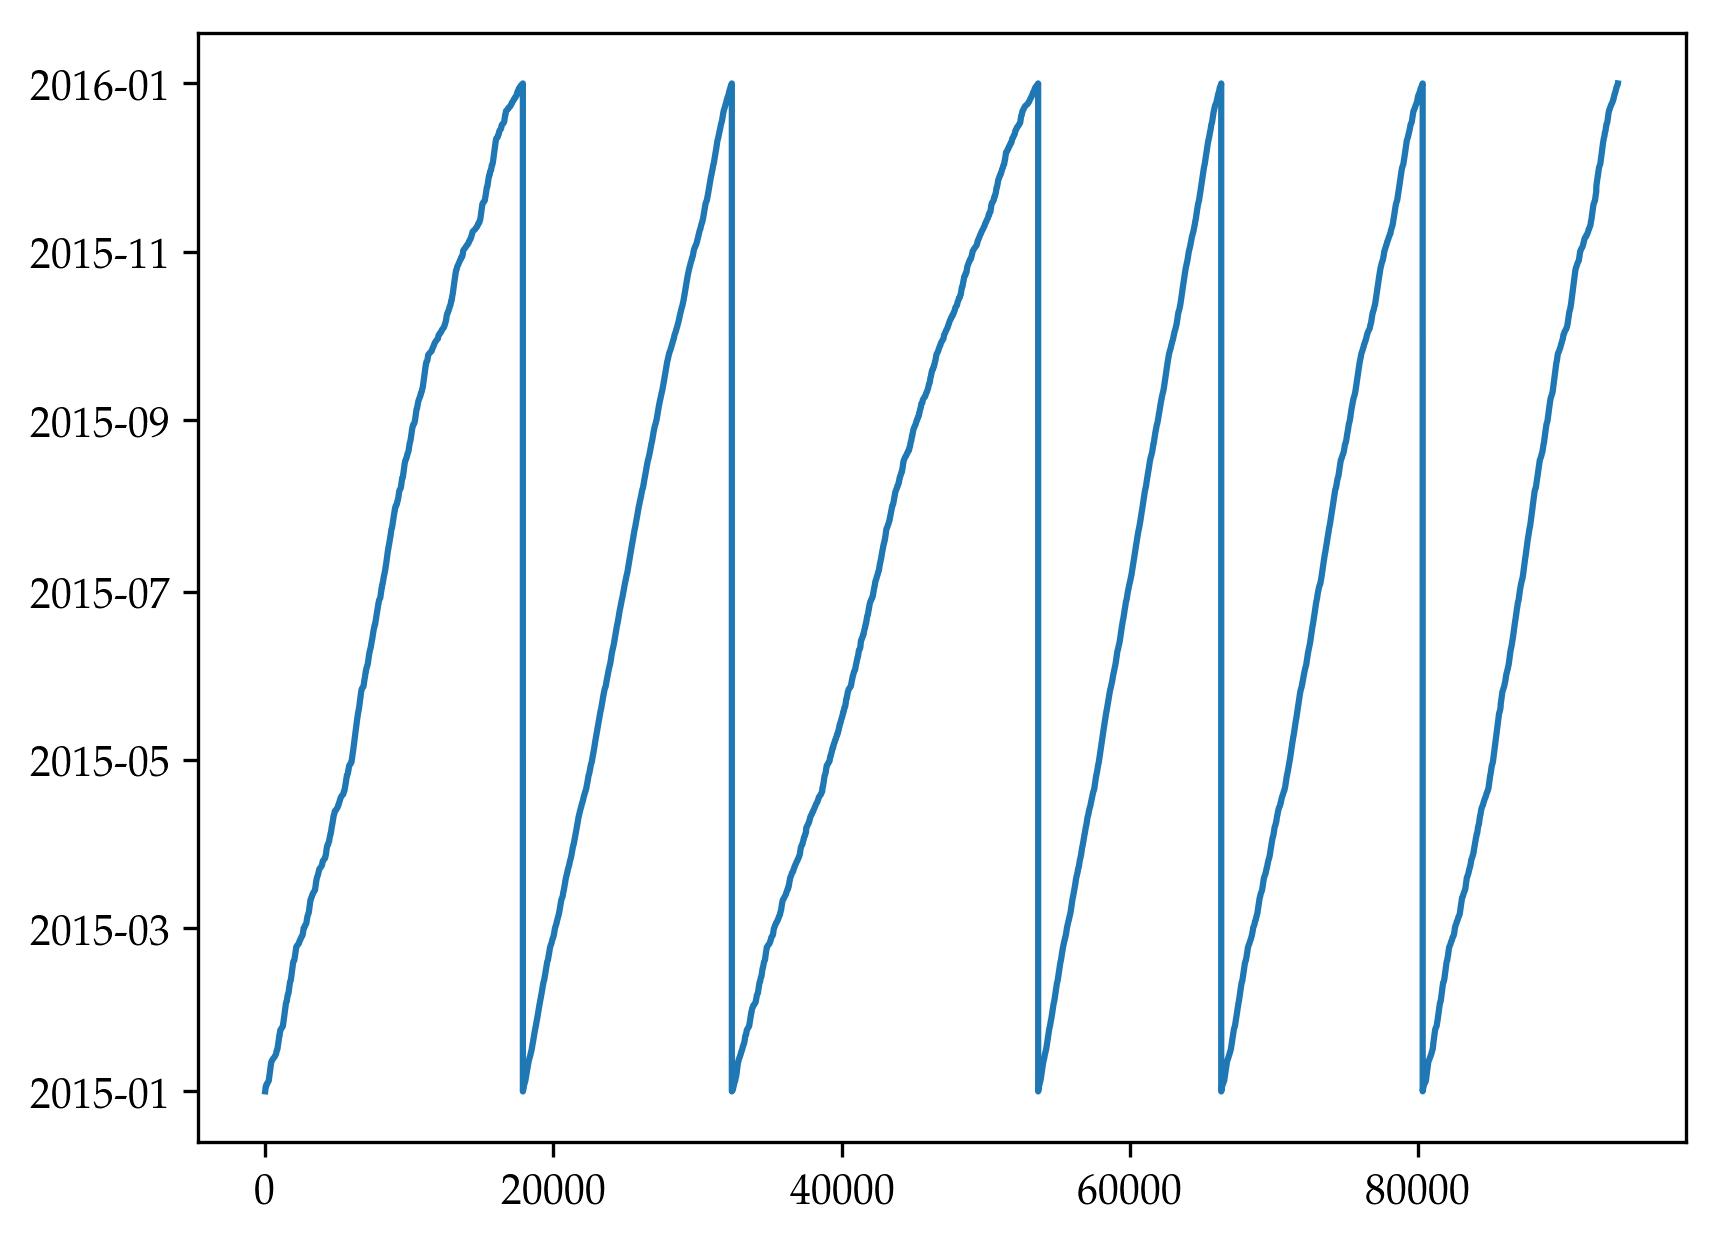

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x137eb5160>

In [23]:
plt.plot(hourly_cat[:ts])

In [34]:
dt_start=DateTime(2015,1,1,0,0,0)
increm=(maximum(hourly_cat[:ts])-minimum(hourly_cat[:ts])) / 15
window=3*increm
using Statistics: mean
using TempModel: subset

while true
    global dt_start
    dt_end=dt_start+window
    savemodel_dir = joinpath(save_dir, "predictions_from_nearby", GPmodel)
    if !isdir(savemodel_dir)
        mkdir(savemodel_dir)
    end
    savemodel_dir = joinpath(savemodel_dir, ICAO)
    if !isdir(savemodel_dir)
        mkdir(savemodel_dir)
    end
    hourly_data = hourly_cat
    stationDF = isd_nearest_and_test
    target=1
    from = dt_start
    to = dt_end
#     from = Date(dt_start)
#     to = Date(dt_end)
    @show from
    @show to
    
    hourly_train = hourly_data[hourly_data[:station].!=target,:]
    hourly_test  = hourly_data[hourly_data[:station].==target,:]
    train_subset = subset(hourly_train,from,to)
    avgtemp=DataFrames.by(train_subset, :station,
               df->DataFrame(avgtemp=mean(df[:temp])))
    train_subset = join(train_subset, avgtemp, on=:station)

    train_X_PRJ = stationDF[:X_PRJ][train_subset[:station]]
    train_Y_PRJ = stationDF[:Y_PRJ][train_subset[:station]]
    train_X = [train_subset[:ts_hours] train_X_PRJ train_Y_PRJ]
    train_Y = train_subset[:temp] .- train_subset[:avgtemp]

    test_subset = subset(hourly_test,from,to)
    test_X_PRJ = stationDF[:X_PRJ][test_subset[:station]]
    test_Y_PRJ = stationDF[:Y_PRJ][test_subset[:station]]
    test_X = [test_subset[:ts_hours] test_X_PRJ test_Y_PRJ]
    @show size(train_subset)
    @show size(test_subset)
    
    if dt_end >= maximum(hourly_cat[:ts])
        break
    end
    dt_start+=increm
end

from = 2015-01-01T00:00:00
to = 2015-03-14T23:59:36
size(train_subset) = (14991, 11)
size(test_subset) = (3463, 10)
from = 2015-01-25T07:59:52
to = 2015-04-08T07:59:28
size(train_subset) = (15283, 11)
size(test_subset) = (3426, 10)
from = 2015-02-18T15:59:44
to = 2015-05-02T15:59:20
size(train_subset) = (16542, 11)
size(test_subset) = (4000, 10)
from = 2015-03-14T23:59:36
to = 2015-05-26T23:59:12
size(train_subset) = (15063, 11)
size(test_subset) = (3266, 10)
from = 2015-04-08T07:59:28
to = 2015-06-20T07:59:04
size(train_subset) = (14405, 11)
size(test_subset) = (2989, 10)
from = 2015-05-02T15:59:20
to = 2015-07-14T15:58:56
size(train_subset) = (13182, 11)
size(test_subset) = (2429, 10)
from = 2015-05-26T23:59:12
to = 2015-08-07T23:58:48


Add `using Statistics` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Statistics` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Statistics` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Statistics` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Statistics` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Statistics` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Statistics` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Statistics` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Statistics` to your imports.


size(train_subset) = (13090, 11)
size(test_subset) = (2702, 10)
from = 2015-06-20T07:59:04
to = 2015-09-01T07:58:40
size(train_subset) = (13453, 11)
size(test_subset) = (2743, 10)
from = 2015-07-14T15:58:56
to = 2015-09-25T15:58:32
size(train_subset) = (13826, 11)
size(test_subset) = (2974, 10)
from = 2015-08-07T23:58:48
to = 2015-10-19T23:58:24
size(train_subset) = (15608, 11)
size(test_subset) = (3666, 10)
from = 2015-09-01T07:58:40
to = 2015-11-13T07:58:16
size(train_subset) = (16878, 11)
size(test_subset) = (4541, 10)
from = 2015-09-25T15:58:32
to = 2015-12-07T15:58:08
size(train_subset) = (16686, 11)
size(test_subset) = (4447, 10)
from = 2015-10-19T23:58:24
to = 2015-12-31T23:58:00
size(train_subset) = (17243, 11)
size(test_subset) = (4788, 10)
